In [89]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from tqdm.notebook import tqdm

import pandahouse as ph
import swifter

import os
import matplotlib.image as mpimg
import re

In [90]:
sns.set_style('darkgrid')
pd.set_option('display.float_format', '{:.3f}'.format)

plt.rcParams['figure.figsize'] = [15, 10]

In [91]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator',
'user':'student',
'password':'dpo_python_2020'
}

## Загружаем данные
* exp_group = 1 - Все по-старому
* exp_group = 2 - Рекомендации "похожих на лайкнутые постов"


In [92]:
query_ab = '''
select  exp_group,
        case when exp_group = 1 then 'control' else 'test' end as group_name,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes / views as ctr
from    simulator_20231113.feed_actions
where   exp_group in (1, 2) and toDate(time) >= toDate('2023-10-25') and toDate(time) <= toDate('2023-10-31')
group by exp_group, user_id
'''

In [93]:
df_ab = ph.read_clickhouse(query_ab, connection = connection)

In [94]:
df_ab.head(3)

,exp_group,group_name,user_id,likes,views,ctr
0,1,control,109963,3,15,0.200
1,1,control,26117,32,141,0.227
2,1,control,138232,18,73,0.247


#### Проверяем загруженные данные

In [95]:
(
    df_ab
    .groupby('user_id', as_index=False)
    .agg({'group_name': 'nunique'})
)

,user_id,group_name
0,206,1
1,216,1
2,220,1
3,224,1
4,227,1
...,...,...
19892,140052,1
19893,140054,1
19894,140059,1
19895,140060,1


Нет пересечения пользователей из разных групп

In [96]:
(
    df_ab
    .groupby('group_name', as_index=False)
    .agg({'user_id': 'count'})
)

,group_name,user_id
0,control,10020
1,test,9877


Тестовая и контрольная выборки примерно одинаковы

In [97]:
df_ab.head(3)

,exp_group,group_name,user_id,likes,views,ctr
0,1,control,109963,3,15,0.200
1,1,control,26117,32,141,0.227
2,1,control,138232,18,73,0.247


Строим гистаграмму

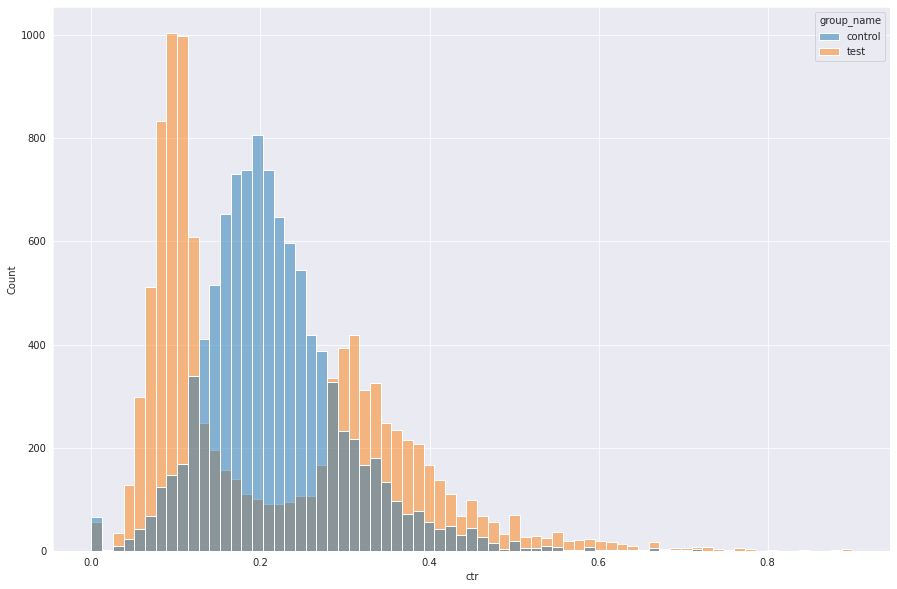

In [98]:
sns.histplot(
    data= df_ab,
    x = 'ctr',
    hue='group_name');

plt.show()

На основе гистограммы можно сделать вывод, что пользователи по-разному отреагировали на нововведение.  
Для части пользователей ключевая метрика просела, для части выросла.  
Это нормальное явление, пользователи по-разному могут реагировать на одинаковые изменения. 

In [99]:
df_ab[df_ab['group_name'] == 'test'].ctr.mean(), df_ab[df_ab['group_name'] == 'control'].ctr.mean()

(0.2161016893237817, 0.216773994120072)

H0 для t-теста:  
средние значения CTR для групп пользователей не отличается  
 H1:  
    средние значения CTR не равны.
      

In [100]:
stat_ttest, p_value_ttest = stats.ttest_ind(
    df_ab[df_ab['group_name'] == 'test'].ctr,
    df_ab[df_ab['group_name'] == 'control'].ctr,
    equal_var=False
)
print(f'Stat: {stat_ttest}, p-value: {p_value_ttest}')

Stat: -0.4051491913112757, p-value: 0.685373331140751


H0 для U-теста Манна-Уитни:  
    вероятность того, что CTR для тестовой группы будет больше CTR для контроольной группы P(X > Y) равна вероятности обратного события P(Y > X)  
H1:  
    вероятности не равны P(X > Y) != P(Y > X)

In [101]:
stat_utest, p_value_utest = stats.mannwhitneyu(
    df_ab[df_ab['group_name'] == 'test'].ctr,
    df_ab[df_ab['group_name'] == 'control'].ctr
)
print(f'Stat: {stat_utest}, p-value: {p_value_utest}')

Stat: 43777627.0, p-value: 4.632205841806026e-45


In [102]:
test = df_ab[df_ab['group_name'] == 'test'].ctr.to_numpy()
control = df_ab[df_ab['group_name'] == 'control'].ctr.to_numpy()


A_gt_b = 0
for _ in tqdm(range(10000)):
    A_gt_b +=  np.random.choice(test) > np.random.choice(control)
print('B', A_gt_b/100, '% случаев Test > Control')

  0%|          | 0/10000 [00:00<?, ?it/s]

B 44.01 % случаев Test > Control


#### Результаты t-теста
Так как p-value для t-теста превышает уровень значимости 0,05, мы не может отвергнуть H0.  
Поэтому на основе проведенного теста мы делаем вывод, что CTR не изменился.
#### Результаты u-теста
Так как p-value для t-теста меньше уровеня значимости 0,05, мы отвергаем H0.  
В 44,43% случаев CTR для тестовой выборки больше CTR контрольной выборки.


## CUPED

Также попробую провести CUPED t-test.

metric


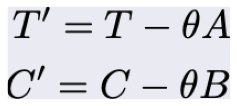

theta


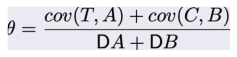

In [103]:
files = os.listdir()
pattern = re.compile(r'.png')
for file in files:
    if '.png' in file:
        print(re.sub(pattern, '', file))
        plt.subplots(figsize=(4, 2))
        plt.imshow(mpimg.imread(file))
        plt.grid(False)
        plt.yticks([])
        plt.xticks([])
        plt.show()

В данном случае важно, чтобы размеры выборок в тестовом периоде и предэкспериментальном были обного размера, 
поэтому будем барть данны за период с 2023-10-05 по  2023-10-24 (период подобран вручную).  



In [104]:
query_aa = '''
select  exp_group,
        case when exp_group = 1 then 'control' else 'test' end as group_name,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes / views as ctr
from    simulator_20231113.feed_actions
where   exp_group in (1, 2) and toDate(time) >= toDate('2023-10-05') and toDate(time) <= toDate('2023-10-24')
group by exp_group, user_id
'''

In [105]:
df_aa = ph.read_clickhouse(query_aa, connection = connection)

In [106]:
# переменные с данными теста
test = df_ab[df_ab['group_name'] == 'test']['ctr'].to_numpy()
control = df_ab[df_ab['group_name'] == 'control']['ctr'].to_numpy()

In [107]:
# данные прдэкспериментального периода (взяты последние значения)
test_before = df_aa[df_aa['group_name'] == 'test']['ctr'][-len(test):].to_numpy()
control_before = df_aa[df_aa['group_name'] == 'control']['ctr'][-len(control):].to_numpy()

In [108]:
# функция для расчтов согласно фрмулам выше
def cuped(control, test, control_before, test_before):
    theta = ((np.cov(control, control_before)[0, 1] + np.cov(test, test_before)[0, 1]) /
                (np.var(control_before) + np.var(test_before)))
    
    control_cup = control - control_before * theta
    test_cup = test - test_before * theta
        
    return control_cup, test_cup

In [109]:
# расчеты
control_cup, test_cup = cuped(
    control, test,
    control_before, test_before
)

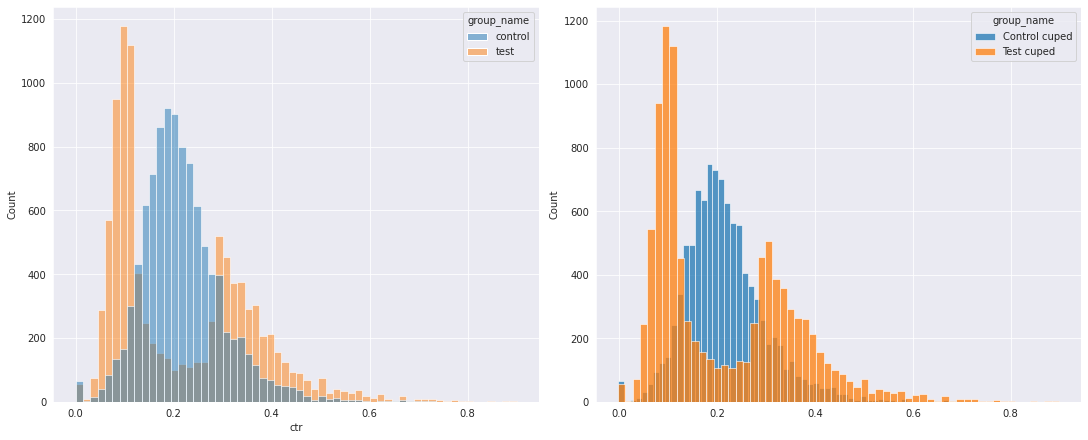

In [110]:
figure, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

sns.histplot(
    data= df_ab,
    x = 'ctr',
    hue='group_name',
    bins=60,
    ax=axs[0]);

sns.histplot(
    x = control_cup,
    label = 'Control cuped',
    bins=60,
    ax=axs[1]);

sns.histplot(
    x = test_cup,
    label = 'Test cuped',
    bins=60,
    ax=axs[1]);

axs[1].legend(title = 'group_name')

plt.show()

In [111]:
test_cup.var() - test.var()

-5.146500280765742e-07

In [112]:
control_cup.var() - control.var()

1.770120410275397e-07

В данном случае дисперсия снизилась незначительно, скорее всего результаты cuped t-теста не будут отличасть от t-теста

In [113]:
stat_ttest_cuped, p_value_ttest_cuped = stats.ttest_ind(
    test_cup,
    control_cup,
    equal_var=False
)
print(f'Stat: {stat_ttest_cuped}, p-value: {p_value_ttest_cuped}')

Stat: -0.4062022373432776, p-value: 0.684599507522432


In [114]:
print(f'Stat: {stat_ttest}, p-value: {p_value_ttest}')

Stat: -0.4051491913112757, p-value: 0.685373331140751


### Итог
В данном случае данный подход к снижению дисперсии не привел к увеличению мощности теста.  
Результаты теста не будет оговорены в итоговых выводах. 

## Smoothed CTR

In [116]:
df_ab.head(3)

,exp_group,group_name,user_id,likes,views,ctr
0,1,control,109963,3,15,0.200
1,1,control,26117,32,141,0.227
2,1,control,138232,18,73,0.247


In [117]:
# функция для сглаживания CTR
def get_smoothed_ctr(group_name, user_likes, user_views, global_ctr_test, global_ctr_control, alpha):
    if group_name == 'test':
        smoothed_ctr = (user_likes + alpha * global_ctr_test) / (user_views + alpha)
    else:
        smoothed_ctr = (user_likes + alpha * global_ctr_control) / (user_views + alpha)
    return smoothed_ctr

In [118]:
# глобальные CTR
global_ctr_test  = df_ab[df_ab['group_name'] == 'test'].likes.sum() / df_ab[df_ab['group_name'] == 'test'].views.sum()
global_ctr_control  = df_ab[df_ab['group_name'] == 'control'].likes.sum() / df_ab[df_ab['group_name'] == 'control'].views.sum()

In [119]:
global_ctr_test, global_ctr_control

(0.20025051027061783, 0.2096041628394293)

In [120]:
df_ab['smoothed_ctr'] = df_ab.swifter.apply(lambda x: get_smoothed_ctr(x['group_name'], x['likes'], x['views'], global_ctr_test, global_ctr_control, 5), axis=1)

Pandas Apply:   0%|          | 0/19897 [00:00<?, ?it/s]

In [121]:
df_ab.sample(3)

,exp_group,group_name,user_id,likes,views,ctr,smoothed_ctr
1359,1,control,137317,20,79,0.253,0.251
12956,1,control,119207,6,45,0.133,0.141
16967,1,control,26228,21,105,0.200,0.200


# Графики сглаженного CTR

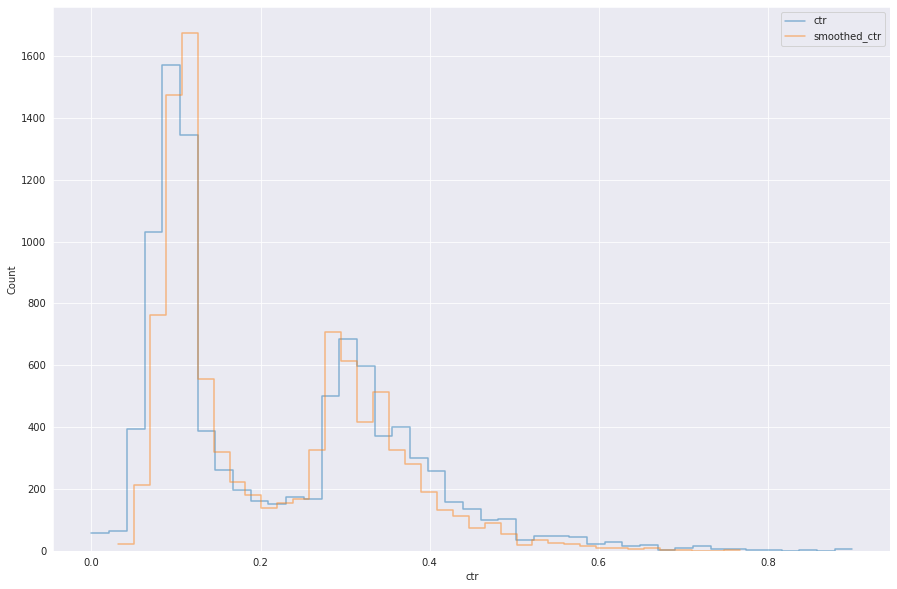

In [122]:
sns.histplot(data = df_ab[df_ab['group_name'] == 'test'], x='ctr', label = 'ctr', alpha=0.5, element='step', fill=False);
sns.histplot(data = df_ab[df_ab['group_name'] == 'test'], x='smoothed_ctr', label = 'smoothed_ctr', alpha=0.5, element='step', fill=False);
plt.legend()
plt.show()

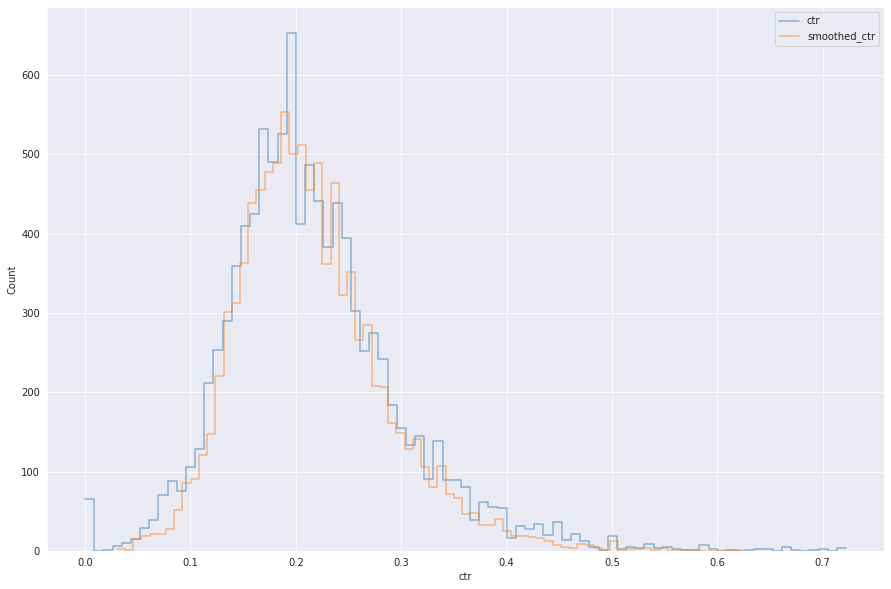

In [123]:
sns.histplot(data = df_ab[df_ab['group_name'] == 'control'], x='ctr', label = 'ctr', alpha=0.5, element='step', fill=False);
sns.histplot(data = df_ab[df_ab['group_name'] == 'control'], x='smoothed_ctr', label = 'smoothed_ctr', alpha=0.5, element='step', fill=False);
plt.legend()
plt.show()

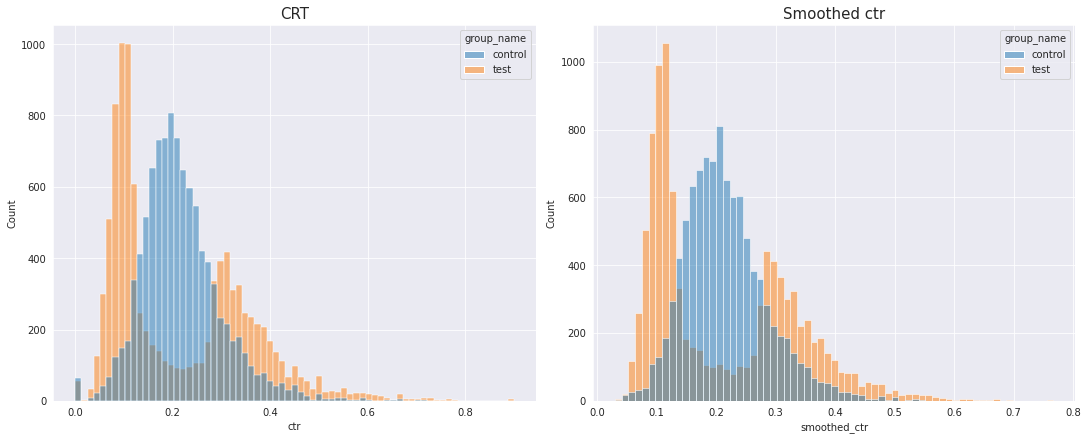

In [124]:
figure, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

sns.histplot(
    data= df_ab,
    x = 'ctr',
    hue='group_name',
    ax=axs[0]);

axs[0].set_title('CRT', fontsize=15)

sns.histplot(
    data = df_ab, 
    x='smoothed_ctr', 
    hue='group_name',
    ax=axs[1]);

axs[1].set_title('Smoothed ctr', fontsize=15)

plt.show()


### Проводим t-тест и u-тест для сглаженного CTR.

In [125]:
stat_ttest_smooth, p_value_ttest_smooth = stats.ttest_ind(
    df_ab[df_ab['group_name'] == 'test'].smoothed_ctr,
    df_ab[df_ab['group_name'] == 'control'].smoothed_ctr,
    equal_var=False
)
print(f't-test: {stat_ttest}, p-value: {p_value_ttest}')

t-test: -0.4051491913112757, p-value: 0.685373331140751


In [126]:
stat_utest_smooth, p_value_utest_smooth = stats.mannwhitneyu(
    df_ab[df_ab['group_name'] == 'test'].smoothed_ctr,
    df_ab[df_ab['group_name'] == 'control'].smoothed_ctr
)
print(f'u-test: {stat_utest}, p-value: {p_value_utest}')

u-test: 43777627.0, p-value: 4.632205841806026e-45


In [127]:
test_smoothed = df_ab[df_ab['group_name'] == 'test'].smoothed_ctr.to_numpy()
control_smoothed = df_ab[df_ab['group_name'] == 'control'].smoothed_ctr.to_numpy()


A_gt_b = 0
for _ in tqdm(range(10000)):
    A_gt_b +=  np.random.choice(test_smoothed) > np.random.choice(control_smoothed)
print('B', A_gt_b/100, '% случаев Test > Control')

  0%|          | 0/10000 [00:00<?, ?it/s]

B 44.35 % случаев Test > Control


#### Результаты t-тест
Так как p-value для t-теста для сглаженного CTR превышает уровень значимости 0,05, мы не может отвергнуть H0.  
Поэтому на основе проведенного теста мы делаем вывод, что CTR не изменился.
#### Реззультаты u-теста
Так как p-value для t-теста меньше уровеня значимости 0,05, мы отвергаем H0.  
В 43,15% случаев сглаженный CTR для тестовой выборки больше CTR контрольной выборки.


In [128]:
print(f'''
t-test
CTR: 
    stat: {stat_ttest}, p-value: {p_value_ttest}
CRT smoothed: 
    stat: {stat_ttest_smooth}, p-value: {p_value_ttest_smooth}

u-test
CTR: 
    stat: {stat_utest}, p-value: {p_value_utest}
CRT smoothed: 
    stat: {stat_utest_smooth}, p-value: {p_value_utest_smooth}
''')


t-test
CTR: 
    stat: -0.4051491913112757, p-value: 0.685373331140751
CRT smoothed: 
    stat: -1.9460491517027683, p-value: 0.05166679015318526

u-test
CTR: 
    stat: 43777627.0, p-value: 4.632205841806026e-45
CRT smoothed: 
    stat: 43439187.0, p-value: 2.396534039374286e-50



Чуствительность тестов на сглаженном CRT увеличилась для обоих тестов.

### Пуассоновский бутстреп для подсчета разницы в CTR

Определяем функцию.

In [129]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstrap1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    
    poisson_bootstrap2 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstrap1 * likes1).sum(axis=1)/(poisson_bootstrap1 * views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstrap2 * likes2).sum(axis=1)/(poisson_bootstrap2 * views2).sum(axis=1)
    
    return globalCTR1, globalCTR2

In [130]:
df_ab.head(2)

,exp_group,group_name,user_id,likes,views,ctr,smoothed_ctr
0,1,control,109963,3,15,0.200,0.202
1,1,control,26117,32,141,0.227,0.226


Трансормируем данные из Pandas в массивы NumPy

In [131]:
likes_test = df_ab[df_ab['group_name'] == 'test'].likes.to_numpy()

views_test = df_ab[df_ab['group_name'] == 'test'].views.to_numpy()

likes_control = df_ab[df_ab['group_name'] == 'control'].likes.to_numpy()

views_control = df_ab[df_ab['group_name'] == 'control'].views.to_numpy()

In [132]:
ctr_test, ctr_control = bootstrap(likes_test, views_test, likes_control, views_control, n_bootstrap=10000)

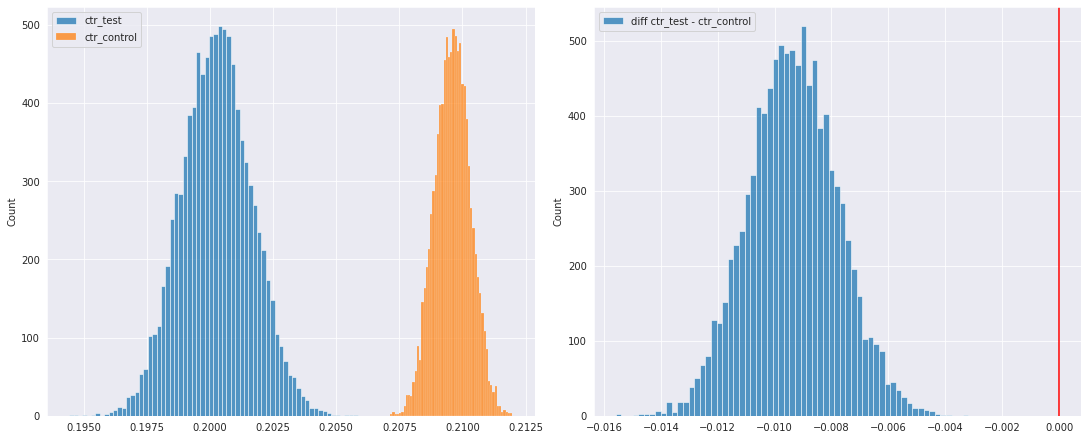

In [133]:
figure, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

sns.histplot(ctr_test, label= 'ctr_test', ax=axs[0]);
sns.histplot(ctr_control, label = 'ctr_control', ax=axs[0]);
axs[0].legend()


sns.histplot(ctr_test - ctr_control, label = 'diff ctr_test - ctr_control', ax=axs[1]);
axs[1].axvline(0, color='red')
axs[1].legend()

plt.show()

In [134]:
stats.ttest_ind(
    ctr_test,
    ctr_control,
    equal_var=False
)

Ttest_indResult(statistic=-598.653766473912, pvalue=0.0)

In [135]:
stats.mannwhitneyu(
    ctr_test,
    ctr_control
)

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

### Результаты бутстрепа

По результатам проведения анализа можно утверждать, что пользователи, для которых работал новый алгоритм рекомендаций реже лайкали просмотренные посты, то есть их вовлеченность снизилась. 
Необходимости рассчитывать довверительные интервалы нет.  

Поэтому следует отказаться от раскатывания алгоритма на всех пользователей.  

### Бакетное преобразование

Запрос для получения данных

In [140]:
query_bucket = '''
select  exp_group,
        case when exp_group = 1 then 'control' else 'test' end as group_name,
        bucket,
        sum(likes)/sum(views) as bucket_ctr,
        quantileExact(0.9)(ctr) as ctr9
from (
  select  exp_group,
          xxHash64(user_id)%50 as bucket,
          user_id,
          sum(action = 'like') as likes,
          sum(action = 'view') as views,
          likes / views as ctr
  from    simulator_20231113.feed_actions
  where   exp_group in (1, 2) and toDate(time) >= toDate('2023-10-25') and toDate(time) <= toDate('2023-10-31')
  group by exp_group, bucket, user_id)
group by exp_group, bucket
'''

In [141]:
df_bucket = ph.read_clickhouse(query_bucket, connection= connection)

In [142]:
df_bucket.head(5)

,exp_group,group_name,bucket,bucket_ctr,ctr9
0,1,control,0,0.201,0.306
1,2,test,0,0.197,0.385
2,1,control,1,0.209,0.311
3,2,test,1,0.210,0.486
4,1,control,2,0.205,0.314


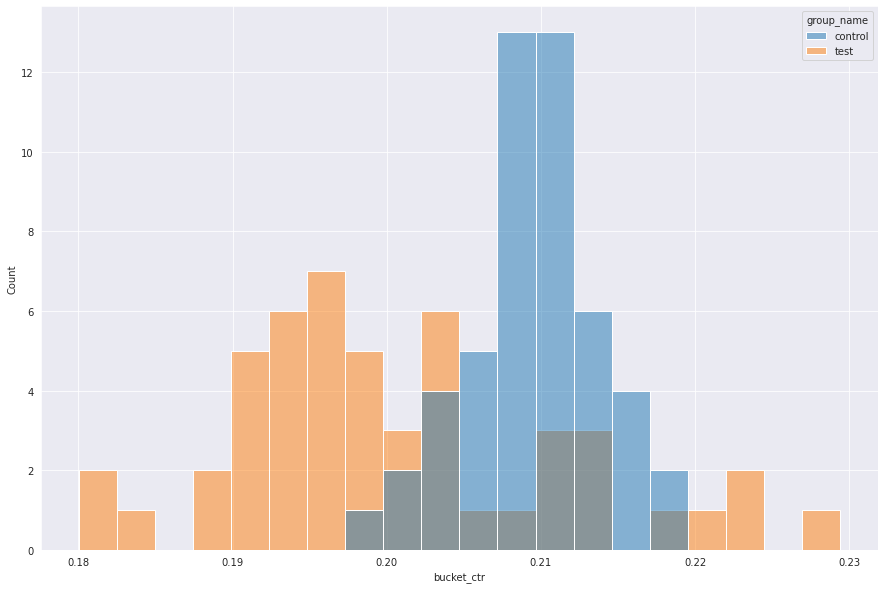

In [143]:
sns.histplot(data = df_bucket, x = 'bucket_ctr', hue = 'group_name', bins = 20);
plt.show()

In [144]:
stat_ttest_bucket, p_value_ttest_bucket = stats.ttest_ind(
    df_bucket[df_bucket['group_name'] == 'test'].bucket_ctr,
    df_bucket[df_bucket['group_name'] == 'control'].bucket_ctr,
    equal_var=False
)

print(f't-test: {stat_ttest_bucket}, p_value: {p_value_ttest_bucket}')

t-test: -5.614819358149381, p_value: 4.592644937473873e-07


In [145]:
stat_utest_bucket, p_value_utest_bucket = stats.mannwhitneyu(
    df_bucket[df_bucket['group_name'] == 'control'].bucket_ctr,
    df_bucket[df_bucket['group_name'] == 'test'].bucket_ctr,
    alternative='two-sided'
)
print(f'u-test: {stat_utest_bucket}, p_value: {p_value_utest_bucket}')

u-test: 1997.0, p_value: 2.6576427804010095e-07


In [146]:
test_bucket = df_bucket[df_bucket['group_name'] == 'test'].bucket_ctr.to_numpy()
control_bucket = df_bucket[df_bucket['group_name'] == 'control'].bucket_ctr.to_numpy()

A_gt_b = 0
for _ in tqdm(range(10000)):
    A_gt_b +=  np.random.choice(test_bucket) > np.random.choice(control_bucket)
print('B', A_gt_b/100, '% случаев Test > Control')

  0%|          | 0/10000 [00:00<?, ?it/s]

B 20.74 % случаев Test > Control


### Результаты оценки разницы среднего CTR с помощью бакетного преобразования, t-теста и U-теста Манна-Уитни  
Оба теста имеют уровень значимости менее 0,05, а значит в обоих случаях мы отвергаем H0.  
Мы наблюдает разницу средних CTR, вероятность, что CTR для тестовой выборки будет больше, чем в контрольной составляет 19,9%.  
Также это подтверждаем гистрграммой со сравнение это метрики для групп.  
На основании этого мы опять приходим к выводу, что раскатывать новый алгоритм на всех пользователей не рекомендуется.  

In [42]:
print(f'''
t-test
CTR: 
    stat: {stat_ttest}, p-value: {p_value_ttest}
CRT smoothed: 
    stat: {stat_ttest_bucket}, p-value: {p_value_ttest_bucket}

u-test
CTR: 
    stat: {stat_utest}, p-value: {p_value_utest}
CRT bucket: 
    stat: {stat_utest_bucket}, p-value: {p_value_utest_bucket}
''')


t-test
CTR: 
    stat: -0.4051491913112757, p-value: 0.685373331140751
CRT smoothed: 
    stat: -5.614819358149381, p-value: 4.592644937473873e-07

u-test
CTR: 
    stat: 43777627.0, p-value: 4.632205841806026e-45
CRT bucket: 
    stat: 1997.0, p-value: 2.6576427804010095e-07



Чуствительность тестов к данным прошедшим бакетное преобразование заметно выше.

### Анализ 90% квантиля CTR

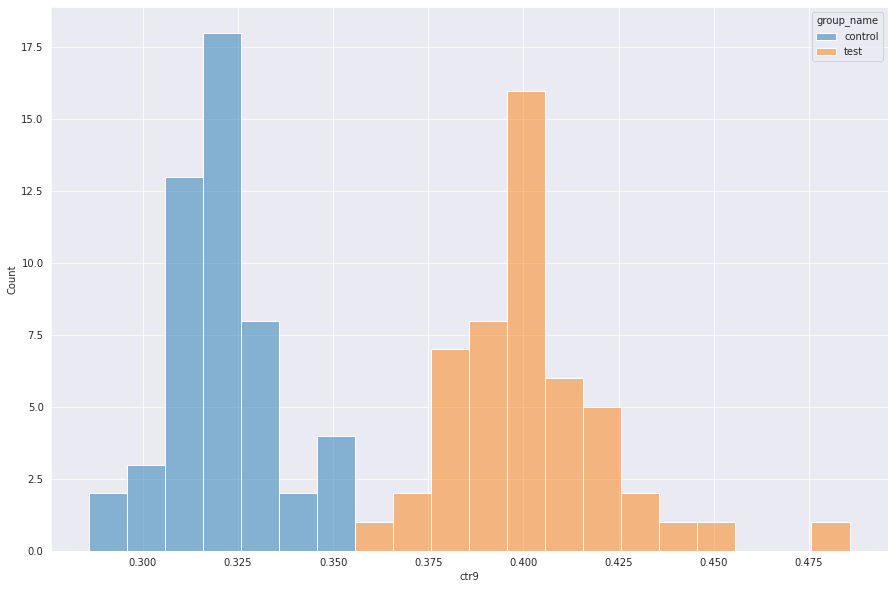

In [147]:
sns.histplot(data = df_bucket, x = 'ctr9', hue = 'group_name', bins = 20);
plt.show()

In [148]:
stat_ttest, p_value_ttest = stats.ttest_ind(
    df_bucket[df_bucket['group_name'] == 'test'].ctr9,
    df_bucket[df_bucket['group_name'] == 'control'].ctr9,
    equal_var=False
)

print(f't-test: {stat_ttest}, p_value: {p_value_ttest}')

t-test: 22.821214612754606, p_value: 4.17295352116894e-38


In [149]:
stat_u_test, p_value_u_test = stats.mannwhitneyu(
    df_bucket[df_bucket['group_name'] == 'test'].ctr9,
    df_bucket[df_bucket['group_name'] == 'control'].ctr9,
    alternative='two-sided'
)
print(f'u-test: {stat_u_test}, p_value: {p_value_u_test}')

u-test: 2500.0, p_value: 6.7601631082665925e-18


In [150]:
test_bucket_ctr9 = df_bucket[df_bucket['group_name'] == 'test'].ctr9.to_numpy()
control_bucket_ctr9 = df_bucket[df_bucket['group_name'] == 'control'].ctr9.to_numpy()

A_gt_b = 0
for _ in tqdm(range(10000)):
    A_gt_b +=  np.random.choice(test_bucket_ctr9) > np.random.choice(control_bucket_ctr9)
print('B', A_gt_b/100, '% случаев Test > Control')

  0%|          | 0/10000 [00:00<?, ?it/s]

B 100.0 % случаев Test > Control


### Выводы на основе анализа разницы 90%-квантиля CTR для пользователей  
На графике для сравнения данных показателей видно, квантиль CTR в тестовой группе выше, чем в контрольной.  
Эта раница подтверждается проведенными t-тестом и U-тестом для который p-value находится ниже заданного уровня значимости.  
Не смотря на то, что использование t-теста для сравнения квантилей может дать некорретный результат, анализ графиков, U-теста, позволяет утверждать, что значение 90% квантиля увеличилось.  



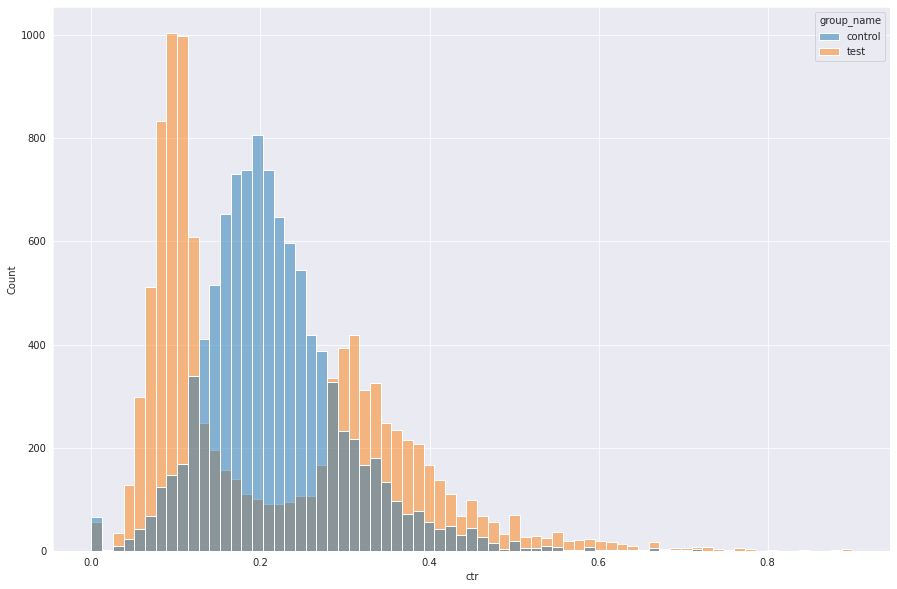

In [151]:
sns.histplot(
    data= df_ab,
    x = 'ctr',
    hue='group_name');

plt.show()

### Итоги

Резльтаты t-теста для CTR не позволили найти различия средних, U-тест позволил выявить определенные изменения в распределении CTR, который виден на графике.  
Для сглаженного CTR результаты t-теста и u-теста остались похожими (но чуствительность тестов заметно выросла).  
Пуассоновский бутстреп позволил выявить разницу между контрольной и тестовой выборками, пользователи с новой системой рекомендация значительно меньше ставят лайков просмотренным постам, то есть уровень их вовлеченности упал.  
Результаты тестов с бакетных преобразованием также указывают на, то что CTR для тестовой группы снизился.  
Однако 90% квантиль CTR заметно увеличился.  

### Рекомендации:
От раскатывания нового алгоритма (рекомендации "похожих на лайкнутые постов") на всех пользователей следует отказаться.  
Но учитывая, что для часть пользователей наоборот стала более вовлеченной (выше продублирован график с CTR, также увеличился 90% квантиль CTR),
стоит болеее подробно изучить влияние нового алгоритма на часть полльзователей.  
Возможно у нас есть категория пользователей, для которой новый алгоритм дает лучшие результаты.  